In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Bulid y

                            y  persist1  persist24
2021-01-30 19:00:00  0.268508  0.501364   0.286664
2021-01-30 20:00:00  0.112552  0.268508   0.091910
2021-01-30 21:00:00  0.011202  0.112552   0.052121
2021-01-30 22:00:00  0.037928  0.011202   0.049943
2021-01-30 23:00:00  0.034748  0.037928   0.048708


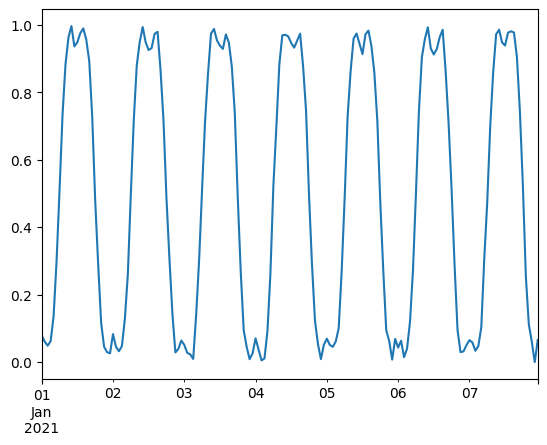

In [2]:
days = 30
freq1 = 2*np.pi/24
freq2 = 3*freq1
freq3 = 4*freq2
phase = 6

t = np.arange(0, 24*days, 1)
y =        np.sin(freq1*(t-phase)) \
    + 0.2*np.sin(freq2*(t-phase)) \
    + 0.1*np.random.rand(len(t))
    
y -= y.min()
y = y/y.max()

df = pd.DataFrame({'y':y},index=pd.date_range('2021-1-1 0:00',periods=len(t),freq='1h'))

df['persist1'] = df.y.shift(1)
df['persist24'] = df.y.shift(24)

df = df.bfill()

df.y[:168].plot();

print(df.tail(5))

In [3]:
#train = df[:int(0.9*len(df))]
#test =  df[int(0.9*len(df)):]
#model = ARIMA(train.y, order=(5,2,0))
#model_fit = model.fit()
#print(model_fit.summary())
#residuals = DataFrame(model_fit.resid)
#residuals.plot(title='Residuals');
#residuals.plot(kind='kde',title='Density plot of residuals');
#print(residuals.describe())

# Train arima and forecast 1 step ahead

And repeat many times

## NB

This method builds the likelihood from errors across all hours of the day

Not just, say, the 12:00-13:00 error distribution of ARIMA

Also not using sarima for some reason

/home/mjw/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mjw/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mjw/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


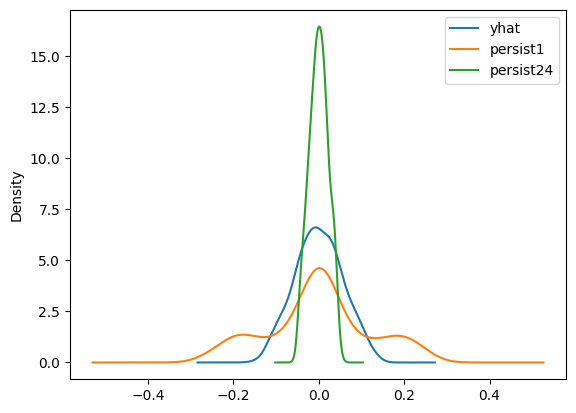

In [4]:
ehat, ep1, ep24 = [], [], []
n_train = 10*24
#for i in [int(24*(x+0.5)) for x in range(n_train//24,90)]:
for i in range(n_train,int(0.9*len(df))):
#for i in range(n_train,n_train+2):
    train = df[(i-n_train):i]
    valid =  df[ i         : ]
    model = ARIMA(train.y, order=(5,2,0))
    model_fit = model.fit()
    yhat = model_fit.forecast().iloc[0]
    y = valid.y.iloc[0]
    ehat.append(y - yhat)
    ep1.append(y - valid.persist1.iloc[0])
    ep24.append(y - valid.persist24.iloc[0])
e = DataFrame({'yhat':ehat,'persist1':ep1,'persist24':ep24})
e.describe()
e.plot(kind='kde');

<Axes: >

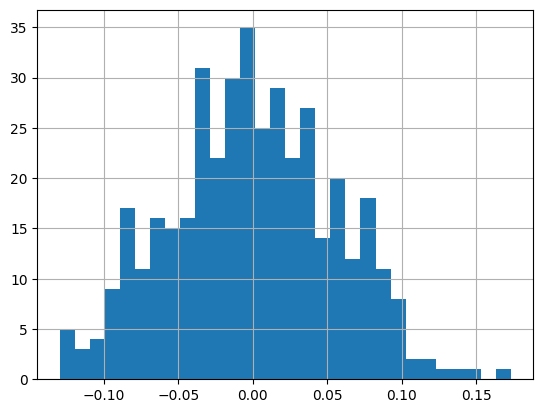

In [19]:
e.yhat.hist(bins=30)

<Axes: >

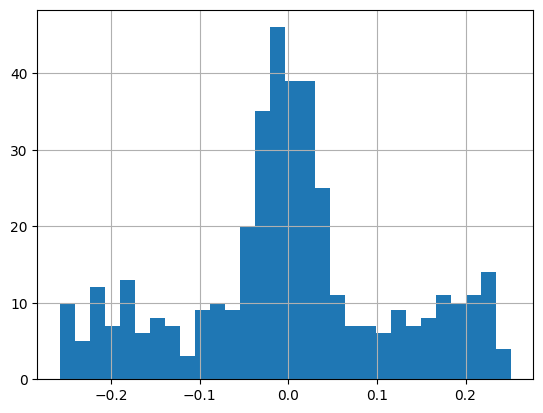

In [20]:
e.persist1.hist(bins=30)

<Axes: >

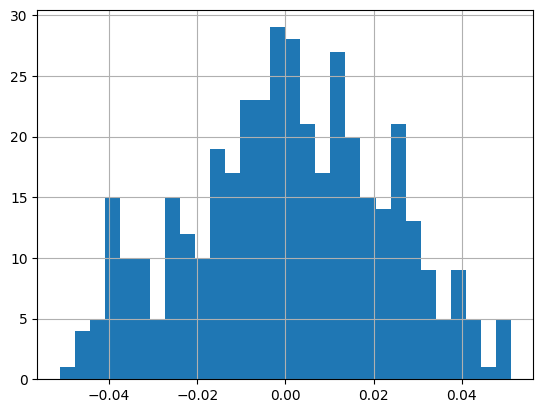

In [21]:
e.persist24.hist(bins=30)

In [ ]:
#train = df[:int(0.9*len(df))]
#test =  df[int(0.9*len(df)):]
#model = ARIMA(train.y, order=(5,2,0))
#model_fit = model.fit()
#yhat = model_fit.forecast()[0]
#print(model_fit.summary())
#residuals = DataFrame(model_fit.resid)
#residuals.plot(title='Residuals');
#residuals.plot(kind='kde',title='Density plot of residuals');
#print(residuals.describe())

# Single test

In [25]:
i = int(0.95*len(df))

train = df[i-(i*n_train):i]
test =  df[i       : ]
h = test.index[0].hour
model = ARIMA(train.y, order=(5,2,0))
model_fit = model.fit()
yhat = model_fit.forecast().iloc[0]

print(test.index[0],yhat)

2021-01-29 12:00:00 0.9107629876450022


In [27]:
persist1 =  test.persist1.iloc[0]
persist24 = test.persist24.iloc[0]
y =         test.y.iloc[0]

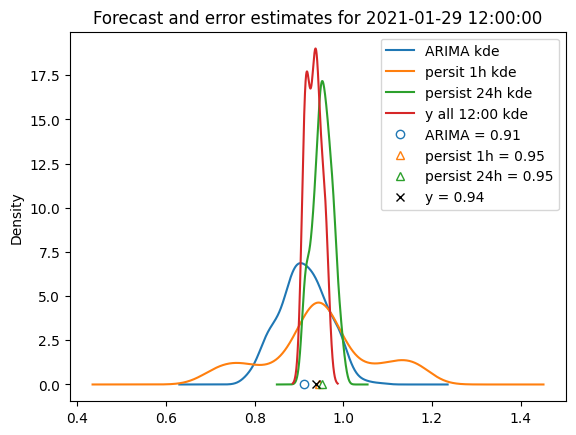

In [ ]:
title = f'Forecast and error estimates for {test.index[0]}'

fig = DataFrame({'yhat':e.yhat+yhat,'persist1':e.persist1+persist1,'persist24':e.persist24+persist24}).plot(kind='kde');
fig = df[df.index.hour==h].y.plot(kind='kde');
plt.plot([yhat],        [0], marker='o', markeredgecolor='tab:blue',   markerfacecolor='white', linewidth=0)
plt.plot([persist1],    [0], marker='^', markeredgecolor='tab:orange', markerfacecolor='white', linewidth=0)
plt.plot([persist24],   [0], marker='^', markeredgecolor='tab:green',  markerfacecolor='white', linewidth=0)
plt.plot([y],           [0], marker='x', markeredgecolor='black'       markerfacecolor='black', linewidth=0)
plt.title(title)
fig.legend(['ARIMA kde','persit 1h kde','persist 24h kde',f'y all {h}:00 kde',\
    f'ARIMA = {yhat:.2f}', f'persist 1h = {persist1:.2f}', f'persist 24h = {persist24:.2f}', f'y = {y:.2f}'])